In [1]:
df_summary = 0

In [2]:
df_score = 0

c:\Users\nibas\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\nibas\.cache\kagglehub\datasets\snap\amazon-fine-food-reviews\versions\2
   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                             

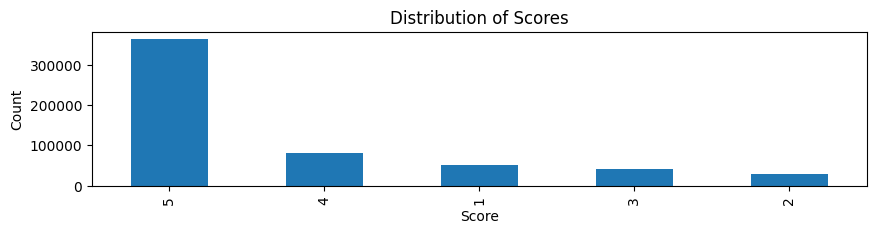

Score: 5 - Summary: Wonderful!
Score: 4 - Summary: My dog loves these
Score: 5 - Summary: Positive
Score: 5 - Summary: yummi for the cats
Score: 3 - Summary: Too thick
Score: 5 - Summary: My dog's buddy!
Score: 5 - Summary: Delish!!!!
Score: 5 - Summary: Wow is this some GOOD stuff!
Score: 5 - Summary: yummy decaf coffee
Score: 4 - Summary: fun sprinkles
After lowercase transformation:
Score: 5 - Summary: harry potter jelly beans
Score: 5 - Summary: perfect for those lonely nights!
Score: 4 - Summary: moist and just the right size
Score: 5 - Summary: excellent formula
Score: 5 - Summary: don't fall prey to fads and anecdotal reviews
Score: 3 - Summary: tasters choice coffee
Score: 5 - Summary: the freshest, fights edema!
Score: 5 - Summary: helps slow breast milk production
Score: 3 - Summary: skeptical, but great
Score: 5 - Summary: chocolate covered halvah bar
After URL replacement:
Score: 5 - Summary: love these sweet sweeties
Score: 3 - Summary: dry. easy to tell that it's fat-free

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nibas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Original words: ['The', 'cats', 'are', 'running', 'and', 'jumping', 'in', 'the', 'fields']
Stemmed words: ['the', 'cat', 'are', 'run', 'and', 'jump', 'in', 'the', 'field']
Lemmatized words: ['The', 'cat', 'are', 'running', 'and', 'jumping', 'in', 'the', 'field']

Lemmatized summaries:
0    good quality dog food
1               advertised
2              delight say
3           cough medicine
4              great taffy
Name: Summary, dtype: object


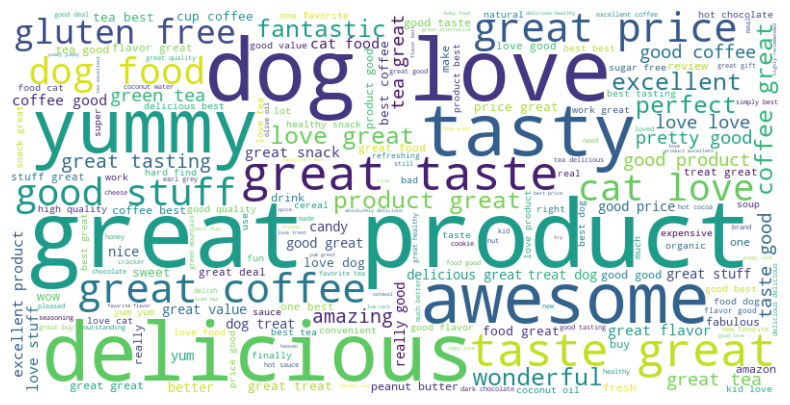

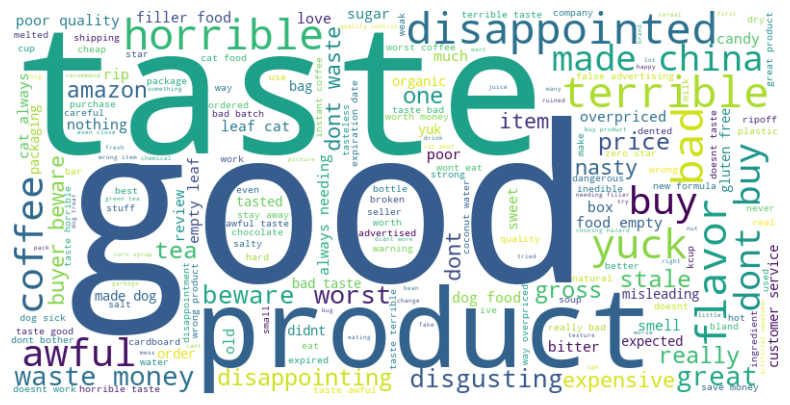

In [3]:
# This code is downloading the notebook from GitHub and running it
import requests
from pathlib import Path
url = "https://raw.githubusercontent.com/nbakas/NLP/refs/heads/main/02-Preprocessing.ipynb"
filename = url.split("/")[-1]
local_path = Path.cwd() / filename
response = requests.get(url)
response.raise_for_status()
local_path.write_bytes(response.content)
%run $local_path

In [4]:
import torch
import random
import numpy as np
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
random.seed(42)
np.random.seed(42)

In [5]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from datetime import datetime

# Example preprocessing: tokenize and build vocab

In [25]:
from collections import Counter
import torch
from torch.utils.data import Dataset


class TextDataset(Dataset):
    """A minimal Dataset for turning raw sentences into fixed-length
    sequences of token IDs that can be fed to a neural network.

    Parameters
    ----------
    texts : List[str]
        Sentences/documents to be classified.
    labels : List[int]
        Integer class labels (e.g. 1-5 star ratings).
    vocab : Dict[str, int], optional
        Pre-built mapping from token → integer index. If *None*, one will
        be built from *texts*.
    max_len : int, default=20
        Sentences longer than *max_len* are truncated; shorter ones are
        padded with the <PAD> token so every sample has identical length.
    """

    def __init__(self, texts, labels, vocab=None, max_len: int = 20):
        self.max_len = max_len

        # Tokenise each sentence by simple whitespace splitting and make
        # everything lowercase so that "Dog" and "dog" map to the same token.
        self.texts = [t.lower().split() for t in texts]
        self.labels = labels

        if vocab is None:
            # Build a frequency counter for all words appearing in the
            # training corpus so we can assign them stable indices.
            counter = Counter(word for text in self.texts for word in text)

            # Reserve *two* indices for special tokens that don't correspond
            # to real words. We start ordinary words at index 2 so that 0 and
            # 1 are free for these special cases:
            #   <PAD> (index 0) — Padding token used purely to make all
            #                     sequences the same length within a batch.
            #                     It carries *no* semantic meaning. Models
            #                     learn to ignore it via masking or by having
            #                     an embedding vector that is not updated.
            #   <UNK> (index 1) — «UNKnown» token assigned to any word that
            #                     was *not* present in the vocabulary at the
            #                     time of building/training. Collapsing every
            #                     unseen word to a single ID keeps the
            #                     vocabulary compact and protects the model
            #                     from crashing when it encounters an
            #                     out-of-vocabulary term at test time.
            # The self.vocab is a dictionary that maps each word to its corresponding index in the vocabulary.
            # The vocabulary is built from the most common words in the training corpus. If input n of most_common is None, then list all element counts.
            # The most_common method returns a list of tuples, where each tuple contains a word and its count in the corpus.
            # The enumerate function is used to pair each word with its index in the vocabulary.
            # The +2 is used to reserve the first two indices for the special tokens <PAD> and <UNK>.
            self.vocab = {word: idx + 2 for idx, (word, _) in enumerate(counter.most_common())}
            self.vocab['<PAD>'] = 0
            # The <PAD> and <UNK> tokens are assigned indices 0 and 1 respectively.
            self.vocab['<UNK>'] = 1
        else:
            # If the vocabulary is already built, then use the pre-built vocabulary.
            self.vocab = vocab

    def __len__(self):
        return len(self.labels)

    def encode_text(self, text):
        """Convert a tokenised *text* (list of str) into a tensor of IDs, which is a tensor of shape (max_len,) and is useful for feeding into the pytorch model.

        Any word that is not in *self.vocab* maps to the <UNK> index so that
        the network receives *some* vector rather than crashing. If the
        resulting sequence is shorter than *max_len* we append <PAD> IDs
        until it reaches the desired length; if it is longer we truncate the
        tail. The output is therefore always of shape (max_len,).
        """

        # Map every word to its ID, defaulting to <UNK> (1) when necessary.
        ids = [self.vocab.get(word, self.vocab['<UNK>']) for word in text]

        # Pad or truncate to fixed length so that we can stack multiple
        # samples into a single tensor of shape (batch_size, max_len).
        if len(ids) < self.max_len:
            # Add as many <PAD> (0) tokens as needed.
            ids += [self.vocab['<PAD>']] * (self.max_len - len(ids))
        else:
            ids = ids[: self.max_len]

        return torch.tensor(ids)

    def __getitem__(self, idx):
        # Fetch the already-tokenised sentence and convert it to IDs.
        text_tensor = self.encode_text(self.texts[idx])

        # Adjust label range from 1-5 → 0-4 because PyTorch's
        # CrossEntropyLoss expects class IDs starting at 0.
        label_tensor = torch.tensor(self.labels[idx] - 1)

        return text_tensor, label_tensor

# Model

In [26]:
# This is the class for the deep learning model. nn.Module is the parent class for all neural network modules in PyTorch.
class DLModel(nn.Module):
    def __init__(
        self, # This is the self parameter, which is the instance of the class
        vocab_size, # This is the size of the vocabulary
        embed_dim, # This is the dimension of the embedding layer
        hidden_dim, # This is the dimension of the hidden layer
        output_dim, # This is the dimension of the output layer
        model_type='RNN', # This is the type of the model
        num_layers=1, # This is the number of layers in the model
        dropout_prob=0.5 # This is the dropout probability
    ):
        super().__init__() # This is the super() function, which is the parent class of the class
        # Initialize the embedding layer with the given vocabulary size and embedding dimension
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        # Initialize the recurrent layer based on the specified model type
        if model_type == 'RNN':
            # Use RNN with specified parameters
            self.rnn = nn.RNN(embed_dim, hidden_dim, num_layers=num_layers,
                              dropout=dropout_prob if num_layers > 1 else 0, batch_first=True)
        elif model_type == 'LSTM':
            # Use LSTM with specified parameters
            self.rnn = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers,
                               dropout=dropout_prob if num_layers > 1 else 0, batch_first=True)
        elif model_type == 'GRU':
            # Use GRU with specified parameters
            self.rnn = nn.GRU(embed_dim, hidden_dim, num_layers=num_layers,
                              dropout=dropout_prob if num_layers > 1 else 0, batch_first=True)
        else:
            # Raise an error if an unsupported model type is provided
            raise ValueError('model_type must be RNN, LSTM, or GRU')

        # Initialize batch normalization for the hidden layer
        self.batch_norm = nn.BatchNorm1d(hidden_dim)
        # Initialize dropout for regularization
        self.dropout = nn.Dropout(dropout_prob)
        # Initialize the fully connected layer for output
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Embed the input sequence
        embedded = self.embedding(x)  # Shape: [batch_size, seq_len, embed_dim]
        # Pass the embedded sequence through the recurrent layer
        output, hidden = self.rnn(embedded)

        # Check if the hidden state is a tuple (for LSTM)
        if isinstance(hidden, tuple):  # For LSTM
            hidden = hidden[0]  # Use the hidden state, not the cell state

        # Use the last layer's hidden state
        hidden = hidden[-1]  # Shape: [batch_size, hidden_dim]
        # Apply batch normalization
        hidden = self.batch_norm(hidden)  # BatchNorm expects shape [batch_size, features]
        # Apply dropout for regularization
        hidden = self.dropout(hidden)
        # Pass through the fully connected layer to get the output
        out = self.fc(hidden)
        return out  # Return the final output

# Prepare data

In [27]:
# Convert the 'df_summary' column of the DataFrame to a list of texts
texts = df_summary.tolist()
# Display the first 5 elements of the list for inspection
texts[:5]

['good quality dog food',
 'advertised',
 'delight say',
 'cough medicine',
 'great taffy']

In [28]:
# Convert the 'df_score' column of the DataFrame to a list of integer labels
labels = df_score.astype(int).tolist()
# Display the first 5 elements of the labels list for inspection
labels[:5]

[5, 1, 4, 2, 5]

In [29]:
# Split the data into training and testing sets
# 'train_test_split' is used to randomly partition the data
# 'texts' and 'labels' are split into training and testing subsets
# 'test_size=0.2' indicates 20% of the data will be used for testing
# 'random_state=42' ensures reproducibility of the split
# 'stratify=labels' ensures the class distribution is preserved in both sets
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

In [30]:
# We will not use the full max_len. 
# Let’s say our longest review title is 120 words, but 95% are under 25.
# Using max_len=120 wastes computation and memory on padding for most inputs.
# Long sequences may slow down training and cause overfitting.
# It makes batches less dense (more padding = less useful gradient info).
# Hence we will use the 95th percentile of the lengths. This gives you a smart cap on sequence length, keeping training efficient without losing too much signal from long examples.
lengths = [len(t.lower().split()) for t in train_texts]
max_len = int(np.percentile(lengths, 95))  # or max(lengths) if you want the absolute max
max_len

6

In [31]:
train_dataset = TextDataset(train_texts, train_labels, max_len=max_len)
test_dataset = TextDataset(test_texts, test_labels, vocab=train_dataset.vocab, max_len=max_len)

In [32]:
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512)

# Hyperparameters

In [33]:
# Determine the size of the vocabulary from the training dataset
vocab_size = len(train_dataset.vocab)
# Set the embedding dimension for the model
embed_dim = 384
# Set the hidden layer dimension for the model
hidden_dim = 256
# Define the output dimension, corresponding to the number of classes (1-5 stars)
output_dim = 5  # 5 classes (1-5 stars)
# Specify the type of model to use; options include 'RNN', 'LSTM', or 'GRU'
model_type = 'LSTM'  # <-- CHANGE HERE to 'RNN' or 'LSTM' or 'GRU'
# Set the number of layers in the model
number_of_layers = 1

# Model, loss, optimizer

In [34]:
# Check if CUDA (GPU support) is available and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Display the device being used (either 'cuda' for GPU or 'cpu' for CPU)
device

device(type='cpu')

In [35]:
# Initialize the deep learning model with the specified parameters:
# - vocab_size: size of the vocabulary from the training dataset
# - embed_dim: dimension of the embedding layer
# - hidden_dim: dimension of the hidden layer
# - output_dim: number of output classes (1-5 stars)
# - model_type: type of model to use ('RNN', 'LSTM', or 'GRU')
# - num_layers: number of layers in the model
# Move the model to the specified device (GPU if available, otherwise CPU)
model = DLModel(vocab_size, embed_dim, hidden_dim, output_dim, model_type, num_layers=number_of_layers).to(device)

In [36]:
# The criterion is the loss function used to evaluate the performance of the model during training.
# It measures the difference between the predicted outputs and the actual target values.
# In this context, we are using CrossEntropyLoss, which is suitable for multi-class classification problems.
# This loss function computes the cross-entropy loss between the predicted class probabilities and the true class labels.
# It is particularly effective for tasks where the model outputs a probability distribution over multiple classes.
criterion = nn.CrossEntropyLoss()

In [37]:
# Initialize the optimizer for the model's parameters using the Adam optimization algorithm.
# Adam is an adaptive learning rate optimization algorithm that's been designed specifically for training deep neural networks.
# It combines the advantages of two other extensions of stochastic gradient descent: AdaGrad and RMSProp.
# This optimizer will adjust the learning rate for each parameter dynamically, which can lead to faster convergence.
optimizer = optim.Adam(model.parameters())

In [38]:
# Set the number of epochs for training the model
# An epoch is one complete forward and backward pass of all the training examples
# More epochs can lead to better training but may also cause overfitting
nof_epochs = 5

In [39]:
def evaluate_model(model, train_loader, test_loader, criterion, device, train_accuracies, test_accuracies, test_losses, epoch, train_loss):
    # Initialize variables to track test loss and correct predictions
    test_loss = 0
    correct_train = 0
    correct_test = 0
    total_train = 0
    total_test = 0

    # Calculate train accuracy
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation for efficiency
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to the specified device
            outputs = model(inputs)  # Forward pass: compute model output
            preds = outputs.argmax(dim=1)  # Get predicted class by finding the index of the max log-probability
            correct_train += (preds == targets).sum().item()  # Count correct predictions
            total_train += targets.size(0)  # Count total samples
    train_accuracy = correct_train / total_train  # Calculate train accuracy
    train_accuracies.append(train_accuracy)  # Append train accuracy to the list

    # Calculate test loss and accuracy
    with torch.no_grad():  # Disable gradient calculation for efficiency
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to the specified device
            outputs = model(inputs)  # Forward pass: compute model output
            loss = criterion(outputs, targets)  # Compute loss
            test_loss += loss.item()  # Accumulate test loss
            preds = outputs.argmax(dim=1)  # Get predicted class by finding the index of the max log-probability
            correct_test += (preds == targets).sum().item()  # Count correct predictions
            total_test += targets.size(0)  # Count total samples
    test_loss /= len(test_loader)  # Average test loss over all batches
    test_losses.append(test_loss)  # Append test loss to the list
    test_accuracy = correct_test / total_test  # Calculate test accuracy
    test_accuracies.append(test_accuracy)  # Append test accuracy to the list

    print(100*"=")  # Print separator for readability
    # Print current epoch, train loss, test loss, train accuracy, and test accuracy
    print(f"{datetime.now().replace(microsecond=0)}, Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")
    print(100*"=")  # Print separator for readability

In [40]:
# Import the time module to work with time-related functions
import time
# Record the current time to measure the elapsed time during training
start_time = time.time()

In [41]:
# Initialize lists to store training and testing accuracies for each epoch
train_accuracies = []
test_accuracies = []

# Initialize lists to store training and testing losses for each epoch
train_losses = []
test_losses = []

# Initial Accuracy

In [42]:
train_loss = sum(criterion(model(inputs.to(device)), targets.to(device)).item() for inputs, targets in train_loader) / len(train_loader)
train_losses.append(train_loss)
train_loss

1.7870837543893048

In [43]:
evaluate_model(model, train_loader, test_loader, criterion, device, train_accuracies, test_accuracies, test_losses, -1, train_loss)

2025-04-30 23:20:32, Epoch 0, Train Loss: 1.7871, Test Loss: 1.6918, Train Accuracy: 0.1666, Test Accuracy: 0.1692


# Training loop

In [44]:
# Loop over each epoch
for epoch in range(nof_epochs):
    model.train()  # Set the model to training mode
    train_loss = 0  # Initialize training loss for the current epoch
    # Loop over each batch in the training data
    for idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)  # Move data to the specified device

        optimizer.zero_grad()  # Reset gradients for the optimizer
        outputs = model(inputs)  # Forward pass: compute model output
        loss = criterion(outputs, targets)  # Compute loss
        loss.backward()  # Backward pass: compute gradients
        optimizer.step()  # Update model parameters

        train_loss += loss.item()  # Accumulate training loss

        # Print progress every 10% of the training data
        if idx % (len(train_loader) // 10) == 0:
           print(f"{datetime.now().replace(microsecond=0)}, Epoch {epoch+1}, Batch {idx+1}/{len(train_loader)}, Train Loss: {train_loss/(idx+1):.4f}, Elapsed: {(time.time() - start_time)/60:.5f} min")
    train_loss = train_loss / len(train_loader)  # Average training loss over all batches
    train_losses.append(train_loss)  # Append training loss to the list

    # Evaluate the model on training and test data
    evaluate_model(model, train_loader, test_loader, criterion, device, train_accuracies, test_accuracies, test_losses, epoch, train_loss)

2025-04-30 23:20:32, Epoch 1, Batch 1/889, Train Loss: 1.7725, Elapsed: 0.91383 min
2025-04-30 23:20:44, Epoch 1, Batch 89/889, Train Loss: 1.3886, Elapsed: 1.12330 min
2025-04-30 23:20:57, Epoch 1, Batch 177/889, Train Loss: 1.2085, Elapsed: 1.32837 min
2025-04-30 23:21:09, Epoch 1, Batch 265/889, Train Loss: 1.1197, Elapsed: 1.53171 min
2025-04-30 23:21:21, Epoch 1, Batch 353/889, Train Loss: 1.0682, Elapsed: 1.73404 min
2025-04-30 23:21:34, Epoch 1, Batch 441/889, Train Loss: 1.0336, Elapsed: 1.94361 min
2025-04-30 23:21:47, Epoch 1, Batch 529/889, Train Loss: 1.0068, Elapsed: 2.16996 min
2025-04-30 23:22:01, Epoch 1, Batch 617/889, Train Loss: 0.9870, Elapsed: 2.40853 min
2025-04-30 23:22:18, Epoch 1, Batch 705/889, Train Loss: 0.9697, Elapsed: 2.68450 min
2025-04-30 23:22:34, Epoch 1, Batch 793/889, Train Loss: 0.9563, Elapsed: 2.95096 min
2025-04-30 23:22:52, Epoch 1, Batch 881/889, Train Loss: 0.9443, Elapsed: 3.24298 min
2025-04-30 23:23:25, Epoch 1, Train Loss: 0.9434, Test Lo

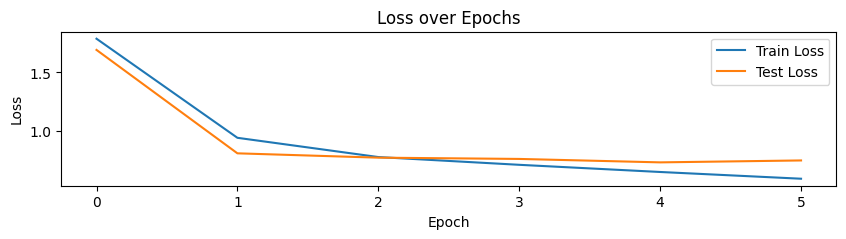

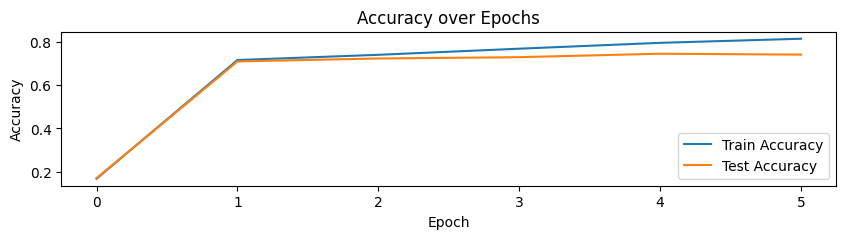

In [45]:
import matplotlib.pyplot as plt  # Import the matplotlib library for plotting

# Plot training and test loss
plt.figure(figsize=(10, 2))  # Create a new figure with a specified size
plt.plot(train_losses, label='Train Loss')  # Plot the training loss with a label
plt.plot(test_losses, label='Test Loss')  # Plot the test loss with a label
plt.title('Loss over Epochs')  # Set the title of the plot
plt.xlabel('Epoch')  # Set the x-axis label
plt.ylabel('Loss')  # Set the y-axis label
plt.legend()  # Display the legend to differentiate between plots
plt.show()  # Show the plot

# Plot training and test accuracy
plt.figure(figsize=(10, 2))  # Create another figure for accuracy plots
plt.plot(train_accuracies, label='Train Accuracy')  # Plot the training accuracy with a label
plt.plot(test_accuracies, label='Test Accuracy')  # Plot the test accuracy with a label
plt.title('Accuracy over Epochs')  # Set the title of the accuracy plot
plt.xlabel('Epoch')  # Set the x-axis label for accuracy
plt.ylabel('Accuracy')  # Set the y-axis label for accuracy
plt.legend()  # Display the legend for accuracy plots
plt.show()  # Show the accuracy plot


# Test accuracy

In [46]:
from sklearn.metrics import classification_report  # Import classification_report from sklearn.metrics for evaluation

# Test + collect predictions
model.eval()  # Set the model to evaluation mode
all_preds = []  # Initialize a list to store all predictions
all_targets = []  # Initialize a list to store all true targets

with torch.no_grad():  # Disable gradient calculation for efficiency
    for inputs, targets in test_loader:  # Iterate over the test data
        inputs, targets = inputs.to(device), targets.to(device)  # Move data to the specified device
        outputs = model(inputs)  # Get model outputs
        preds = outputs.argmax(dim=1)  # Get predicted class by finding the index of the max log-probability

        all_preds.extend(preds.cpu().numpy())  # Append predictions to the list, converting to numpy array
        all_targets.extend(targets.cpu().numpy())  # Append true targets to the list, converting to numpy array

# Print classification report
print(classification_report(all_targets, all_preds, digits=4))  # Print a detailed classification report


              precision    recall  f1-score   support

           0     0.5839    0.7040    0.6384     10326
           1     0.5101    0.2755    0.3578      5855
           2     0.4398    0.4530    0.4463      8485
           3     0.5467    0.3478    0.4252     16123
           4     0.8350    0.9058    0.8690     72902

    accuracy                         0.7421    113691
   macro avg     0.5831    0.5372    0.5473    113691
weighted avg     0.7251    0.7421    0.7272    113691



In [47]:
from sklearn.metrics import classification_report  # Import classification_report for evaluating model performance

# Train + collect predictions
model.eval()  # Set the model to evaluation mode to disable dropout and batch normalization

all_preds = []  # Initialize a list to store predictions from the model
all_targets = []  # Initialize a list to store true target values

with torch.no_grad():  # Disable gradient calculation for efficiency during evaluation
    for inputs, targets in train_loader:  # Iterate over the training data
        inputs, targets = inputs.to(device), targets.to(device)  # Move data to the specified device (CPU or GPU)
        outputs = model(inputs)  # Get model outputs for the inputs
        preds = outputs.argmax(dim=1)  # Determine predicted class by finding the index of the max log-probability

        all_preds.extend(preds.cpu().numpy())  # Append predictions to the list, converting to numpy array
        all_targets.extend(targets.cpu().numpy())  # Append true targets to the list, converting to numpy array

# Print classification report
print(classification_report(all_targets, all_preds, digits=4))  # Print a detailed classification report with 4 decimal places


              precision    recall  f1-score   support

           0     0.6947    0.8352    0.7585     41942
           1     0.6841    0.4128    0.5149     23914
           2     0.5935    0.6226    0.6077     34155
           3     0.7278    0.4698    0.5710     64532
           4     0.8788    0.9460    0.9111    290220

    accuracy                         0.8159    454763
   macro avg     0.7157    0.6573    0.6726    454763
weighted avg     0.8087    0.8159    0.8052    454763

